In [1]:
from timestamp import *
from geodesy import *
from matplotlib import pyplot as pt
from math import log
import re
from random import sample

In [2]:
MSG = re.compile(r'D[0-9]+-.*')

In [3]:
def read_tower_data(filename):
    with open(filename) as f:
        raw = f.readlines()

        points = []

        for line in raw:
            cl = line.replace("b'",'').replace("'",'').replace('(','').replace('{','').replace(')','').replace('}','')
            ls = cl.split(',')
            p = {}
            for field in ls:
                fs = field.split(':')
                try:

                    if 'T' in fs[0]:
                        p['T'] = TimeStamp(h=int(fs[1]),m=int(fs[2]),s=float(fs[3]))
                        continue
                except:
                    print(fs)
                try:
                    p[fs[0]] = float(fs[1])
                except:
                    p['data'] = field

            points.append(p)
        
        return points


def read_drone_data(filename):
    dfile = open(filename)
    draw = dfile.readlines()
    dfile.close()
    drone_data = []
    
    for line in draw:
        
        lclean = line.replace("b'",'').replace("'",'').replace('(','').replace('{','').replace(')','').replace('}','')
        ls = lclean.split(',')
        
        if ls[0] == '0':
            continue
        
        
        time_str = ls[0].split()[1]
        ts = TimeStamp(stamp=time_str)

        lat = float(ls[1])
        lon = float(ls[2])
        alt = float(ls[3])
        if alt < 30:
            continue
        
        strdata = ''.join(ls[4:-1])

        tsr = ls[-1].split()
        
        ts_rasp = TimeStamp(stamp = tsr[1])
        
        drone_data.append({'abs T':ts,'lon':lon,'lat':lat,'alt':alt,'data':strdata,'rasp T':ts_rasp})
    return drone_data

def cluster(data,i=0):
    clusters = {}
    ind = 0
    for rd in data:
        if rd[i] < 100:
            ind = 100
        elif rd[i] >= 100 and rd[i]<200:
            ind = 200
        elif rd[i] >=200 and rd[i] <300:
            ind = 300
        elif rd[i] >= 300 and rd[i] <400:
            ind = 400
        elif rd[i]>=400 and rd[i] <500:
            ind = 500
        elif rd[i]>=500 and rd[i] <600:
            ind = 600
        elif rd[i] >=600 and rd[i] <700:
            ind = 700
        elif rd[i] >= 700 and rd[0]<800:
            ind = 800
        elif rd[i] >=800 and rd[i] < 850:
            ind = 850
        elif rd[i]>=850 and rd[i]<890:
            ind =900
        elif rd[i] >=890:
            ind = 950

        try:
            clusters[ind][0].append(rd[0])
            clusters[ind][1].append(rd[1])
            clusters[ind][2].append(rd[2])
            clusters[ind][3].append(rd[3])
            clusters[ind][4].append(rd[4])
        except:
            clusters[ind] = [[rd[0]],[rd[1]],[rd[2]],[rd[3]],[rd[4]]]
    return clusters

def rssi_vs_position(data):
    rvp = []
    for d in data:
        if 'rssi' in d['data']:
            ds = d['data'].split('t')
            try:
                rp = (d['lat'],d['lon'],d['alt'],int(ds[1].split(':')[1][0:-4]))
                rvp.append(rp)
            except:
                pass
    return rvp


def rssi_vs_distance(rvp,ref=(50.86227366666667, 4.685484, 46.2)):
    rvd = []
    for rp in rvp:
        d = haversine(ref[0],rp[0],ref[1],rp[1])
        if d > 100:
            rvd.append((d,rp[3],rp[0],rp[1],rp[2]))

    rvd.sort()
    return rvd

def received(data):
    rec = []
    for d in data:
        if 'D' in d['data']:
            rec.append(d)
    return rec

def msg_vs_distance(rec,ref=(50.86227366666667, 4.685484, 46.2)):
    
    mvd = []
    for r in rec:
        d = haversine(ref[0],r['lat'],ref[1],r['lon'])
        mvd.append((d,r['rasp T']))

    mvd.sort()
    return mvd
    

[(50.8628174478198, 4.683956636462093, 42.89899669073333), (50.862059301978924, 4.682930456918715, 45.35642475035694), (50.86169474668278, 4.680829746205712, 42.72275946650334), (50.861023979468186, 4.679089260840485, 40.665189211791784), (50.85999189432477, 4.676872293048831, 44.359806423229045), (50.85989246571537, 4.6766121987027285, 36.882768717568624), (50.85983795640913, 4.676094035407898, 39.36099766899758)]


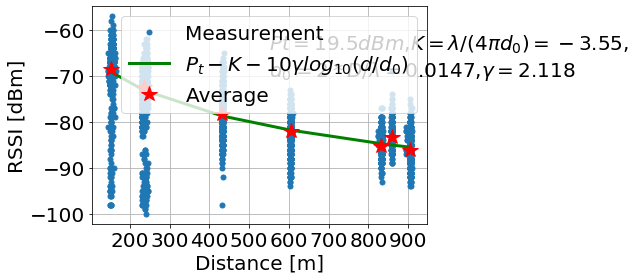

In [4]:
dd = []
for i in range(1,13):
    dd += read_drone_data('log%d.txt'%i)

rvp = rssi_vs_position(dd)
rvd = rssi_vs_distance(rvp)


clusters = cluster(rvd)

res = []
points = []
for k in clusters:
    dist = sum(clusters[k][0])/len(clusters[k][0])
    rssi = sum(clusters[k][1])/len(clusters[k][1])
    lat = sum(clusters[k][2])/len(clusters[k][2])
    lon = sum(clusters[k][3])/len(clusters[k][3])
    alt = sum(clusters[k][4])/len(clusters[k][4])
    if dist > 100:
        res.append((dist,rssi))
        points.append((lat,lon,alt))
    
print(points)
#avg values
d = [x[0] for x in res]
r = [x[1] for x in res]
points = [x[0] for x in res]
#path loss
pl = [19.5-3.55-10*2.118*log(x/0.0147,10) for x in d]


indexes = sample(range(len(rvd)),int(len(rvd)/4))

#points
rssi = [rvd[i][1] for i in indexes]
dist = [rvd[i][0] for i in indexes]
pt.grid(True)
pt.rcParams['figure.figsize'] = 15, 10
pt.plot(dist,rssi,'o',markersize=5,label="Measurement")
pt.plot(d,pl,'g',linewidth=3.0,label="$P_{t}-K-10\gamma log_{10}(d/d_{0})$")
pt.plot(d,r,'r*',markersize=16, label = "Average")
pt.text(550,-70,"$Pt=19.5dBm$,$K=\lambda/(4\pi d_{0})=-3.55$,\n$d_{0}=2*D/\lambda = 0.0147$,$\gamma=2.118$",fontsize=20)
pt.xticks(fontsize=20)
pt.yticks(fontsize=20)
pt.legend(fontsize=20)
pt.xlabel('Distance [m]',fontsize=20)
pt.ylabel('RSSI [dBm]',fontsize=20)
pt.savefig('rssi_vs_distance.pdf', dpi=300, facecolor='w', edgecolor='w',orientation='portrait')
pt.show()
with open('rvd.txt','w') as f:
    for d,r in res:

        print(f'{d};{r}',file = f)

with open('rssi_vs_dist.txt','w') as f:
    for rd in rvd:
        print(f'{rd[0]};{rd[1]}',file = f)

[236.1025223147471, 432.9685373653201, 604.5869000036488, 832.2833817062417, 858.4867848561576, 905.7877029825903]
20
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
557


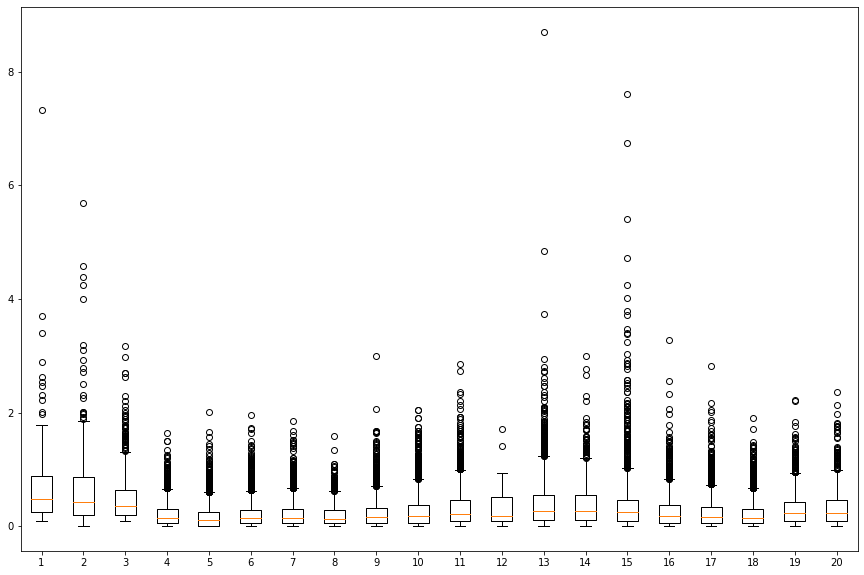

In [5]:
rec = received(dd)
points = [x[0] for x in res[1:]]
print(points)
flights = {}
tdoa = {}
cur = 0
flights[cur] = []
tdoa[cur] = []
flights[cur].append(rec[0])

for i in range(1,len(rec)):
    
    delta = rec[i]['abs T'] - rec[i-1]['abs T']
    if delta.toSeconds() > 240:
        cur += 1
        flights[cur] = []
        tdoa[cur] = []
    flights[cur].append(rec[i])
    dt_a = (rec[i]['rasp T']-rec[i-1]['rasp T']).toSeconds()
    if dt_a > 60:
        continue
    tdoa[cur].append(dt_a)

print(len(flights))
ref=(50.86227366666667, 4.685484, 46.2)
freq = []

print(tdoa.keys())
bp = []
for k in sorted(tdoa.keys()):
    bp.append(tdoa[k])
print(len(bp[1]))
pt.boxplot(bp)
pt.show()


[151.59688281646928, 152.42975636878194, 156.7526183022739, 232.54907229737907, 238.70818380086558, 241.52823915324743, 432.80575796218767, 433.0480026776671, 433.3036460964997, 603.6704518724015, 605.0967565974161, 605.2137271548878, 832.2833817062411, 858.4867848561576, 904.9003837689273, 905.7369900882662, 906.72932465391]


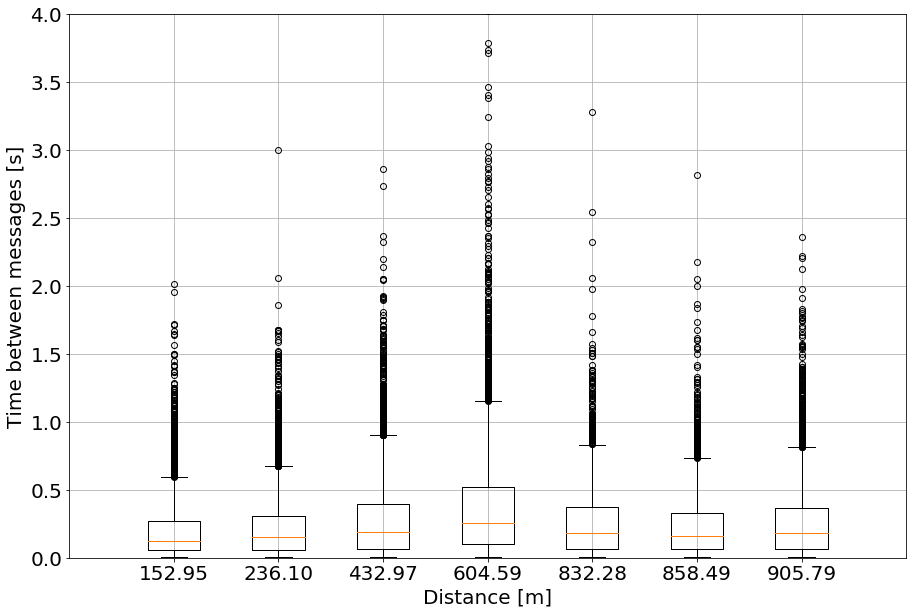

In [12]:
tdoa_vd = {}
vx = [x[0] for x in res[1:]]

for f in flights:
    dt = flights[f][-1]['rasp T']-flights[f][0]['rasp T']
    dts = dt.toSeconds()
    if dts == 0:
        continue
    
    avg_dist = 0
    avg_lat = 0
    avg_lon = 0
    avg_h = 0
    for p in flights[f]:
        avg_dist+=haversine(ref[0],p['lat'],ref[1],p['lon'])
        avg_lat += p['lat']
        avg_lon += p['lon']
        avg_h += p['alt']
        
    
    avg_dist/=len(flights[f])
    avg_lat /= len(flights[f])
    avg_lon/= len(flights[f])
    avg_h /= len(flights[f])
    freq.append((avg_dist,len(flights[f])/dts))
    points.append((avg_lat,avg_lon,avg_h))
    
    for i in range(1,len(flights[f])):
        dt_a = (flights[f][i]['rasp T']-flights[f][i-1]['rasp T']).toSeconds()
        if dt_a > 60:
            continue
        if avg_dist < 100:
            continue
        try:
            
            tdoa_vd[avg_dist].append(dt_a)
        except:
            tdoa_vd[avg_dist] = [dt_a]
            
        


print(sorted(tdoa_vd.keys()))
    
bp = [[] for i in range(7)]
for k in sorted(tdoa_vd.keys()):
    if abs(k-150) < 20:
        bp[0]+=tdoa_vd[k]
    elif abs(k-230)<20:
        bp[1]+=tdoa_vd[k]
    elif abs(k-430)<20:
        bp[2]+=tdoa_vd[k]
    elif abs(k-600)<20:
        bp[3]+=tdoa_vd[k]
    elif abs(k-830)<20:
        bp[4]+=tdoa_vd[k]
    elif abs(k-850)<20:
        bp[5]+=tdoa_vd[k]
    elif abs(k-900)<20:
        bp[6]+=tdoa_vd[k]

pt.boxplot(bp)
pt.axis([0,8,0,4])
pt.xticks([1,2,3,4,5,6,7],['%.2f'%x[0] for x in res],fontsize=20)
pt.yticks(fontsize=20)
pt.xlabel("Distance [m]",fontsize=20)
pt.ylabel("Time between messages [s]",fontsize=20)
pt.grid(True)
pt.savefig('tdoa_drone.pdf', dpi=300, facecolor='w', edgecolor='w',orientation='portrait')
pt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[65.70274294584648, 61.9829508849256, 61.8078195488501, 156.7526183022739, 152.42975636878194, 151.59688281646928, 238.70818380086558, 241.52823915324743, 232.54907229737907, 433.0480026776671, 432.80575796218767, 433.3036460964997, 603.6704518724015, 605.0967565974161, 605.2137271548878, 832.2833817062411, 858.4867848561576, 905.7369900882662, 904.9003837689273, 906.72932465391]
[1.412960760639439, 1.5453060513493289, 2.064396700851878, 4.538784516008047, 5.833021968781018, 4.846930008790342, 4.469502437021452, 4.797097749563355, 0.420003407514281, 3.343560050845372, 3.1216386009205497, 0.3772105421859304, 0.28797761574214087, 0.1790615377107324, 2.5377619045602122, 3.3738954032695307, 4.030944096650099, 0.4258961152912394, 3.0868608344043627, 2.8590889340913295]


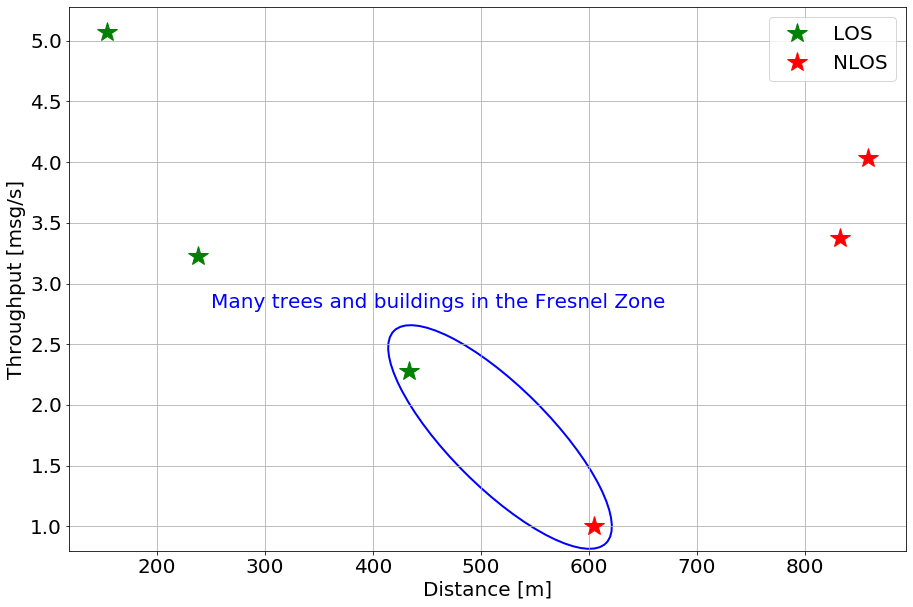

In [7]:
dist = [f[0] for f in freq]
thrp = [f[1] for f in freq]
d = []
t = []
tmp_d = freq[0][0]
tmp_t = freq[0][1]
n = 1
for i in range(1,len(freq)):
    if freq[i][0] - freq[i-1][0] < 10:
        tmp_d += freq[i][0]
        tmp_t += freq[i][1]
        n+=1
    else:
        d.append(tmp_d/n)
        t.append(tmp_t/n)
        n=1
        tmp_d = freq[i][0]
        tmp_t = freq[i][1]
        
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

print(dist)
print(thrp)
pt.grid(True)
pt.plot(d[1:4],t[1:4],'g*',markersize=20,label="LOS")
pt.plot(d[4:],t[4:],'r*',markersize=20,label="NLOS")
ellipse = Ellipse((0, 0), 100,300, color='b', fill=False, linewidth=2)
transf = transforms.Affine2D().rotate_deg(45).translate(500,170)
ellipse.set_transform(transf)
ax = pt.gca()
ax.add_artist(ellipse)
pt.text(250,2.8,"Many trees and buildings in the Fresnel Zone",fontsize=20, color='b')
pt.xticks(fontsize=20)
pt.yticks(fontsize=20)
pt.legend(fontsize=20)
pt.xlabel('Distance [m]',fontsize=20)
pt.ylabel('Throughput [msg/s]',fontsize=20)
pt.savefig('rate_vs_distance.eps', dpi=300, facecolor='w', edgecolor='w',orientation='portrait')
pt.show()